In [72]:
# %pip install torch
# %pip install opencv-python
# %pip install torchvision

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Detecting the Plate Number in the Image or Series of Image

The algorithm for plate number location detection will adapt to the user's input image. The detection process involves identifying contours and analyzing their patterns. Our approach involves  specifically targeting rectangular shapes, since the license plate is often the only object in an image with this shape.

In [74]:
def image_read(image1, image2, title1 = "", title2 = ""):
    fig = plt.figure(figsize = (15, 15))
    ax1 = fig.add_subplot(121)
    ax1.imshow(image1, cmap = "gray")
    ax1.set(xticks = [], yticks = [], title = title1)
    ax2 = fig.add_subplot(122)
    ax2.imshow(image2, cmap = "gray")
    ax2.set(xticks = [], yticks = [], title = title2)

In [75]:
#path = r"/home/zachgoldberg0/ml2_Project/ML2_Project/car-data/images/Cars358.png"

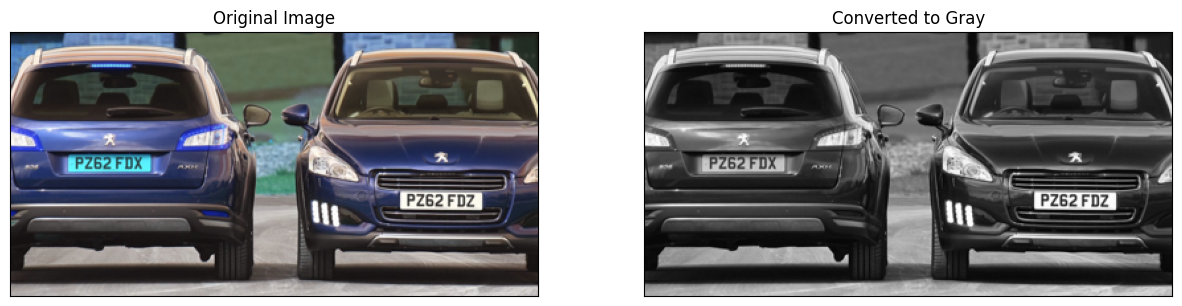

In [76]:
def read_and_smoothen(path):
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #Use bilateral filter to filter out the noise-pixels and smoothen the image
    smooth = cv2.bilateralFilter(gray, 9, 75, 75)
    image_read(image, gray, title1 = "Original Image", title2 = "Converted to Gray")
    return image, smooth, gray

path = r"/home/zachgoldberg0/ml2_Project/ML2_Project/car-data/images/Cars358.png"
image, smooth, gray = read_and_smoothen(path)

In [77]:
# smooth = cv2.bilateralFilter(gray, 9, 75, 75)
# image_read(gray, smooth, title1 = "Gray", title2 = "Smooth")

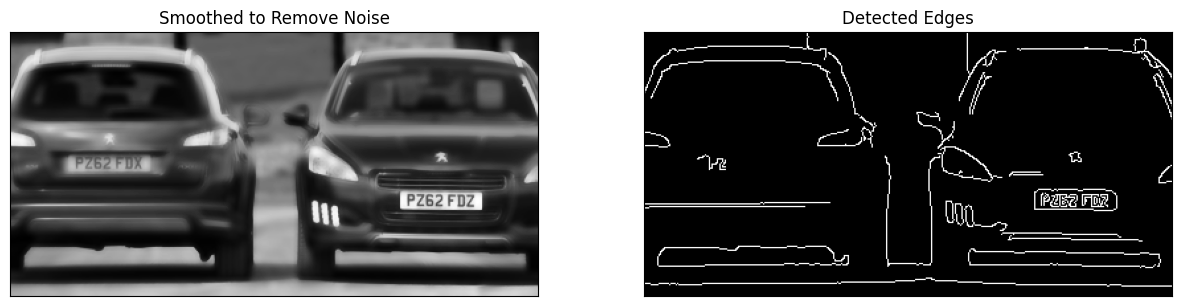

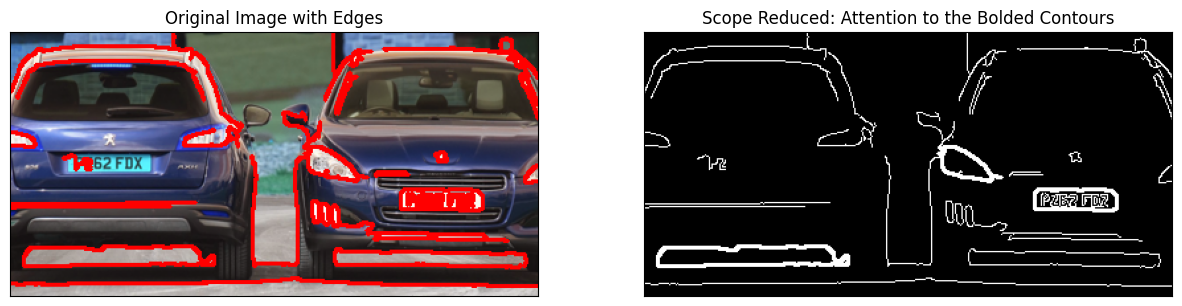

In [78]:
def add_contour_edges_to_image(smooth, image):
    edge = cv2.Canny(smooth, 70, 400)
    image_read(smooth, edge, title1 = "Smoothed to Remove Noise", title2 = "Detected Edges")

    #Combine patterns with the regions
    contours, new = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    image_copy = image.copy()
    _ = cv2.drawContours(image_copy, contours, -1, (255, 0, 0), 2)

    #bring edges/contours to the image
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
    image_reduced = edge.copy()
    _ = cv2.drawContours(image_reduced, contours, -1, (255, 0, 0), 2)
    image_read(image_copy, image_reduced, title1 = "Original Image with Edges", title2 = "Scope Reduced: Attention to the Bolded Contours")

    return contours

contours = add_contour_edges_to_image(smooth, image)

In [79]:
# edge = cv2.Canny(smooth, 70, 400)
# image_read(smooth, edge, title1 = "Smooth", title2 = "Edge")

In [80]:
# contours, new = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# image_copy = image.copy()
# _ = cv2.drawContours(image_copy, contours, -1, (255, 0, 0), 2)
# image_read(edge, image_copy, title1 = "Edge", title2 = "Contours")

In [81]:
# contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
# image_reduced = edge.copy()
# _ = cv2.drawContours(image_reduced, contours, -1, (255, 0, 0), 2)
# image_read(image_copy, image_reduced, title1 = "Original", title2 = "Reduced")

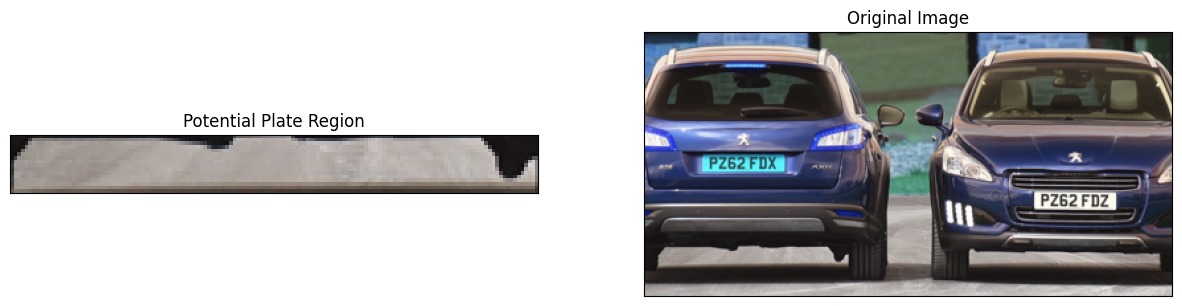

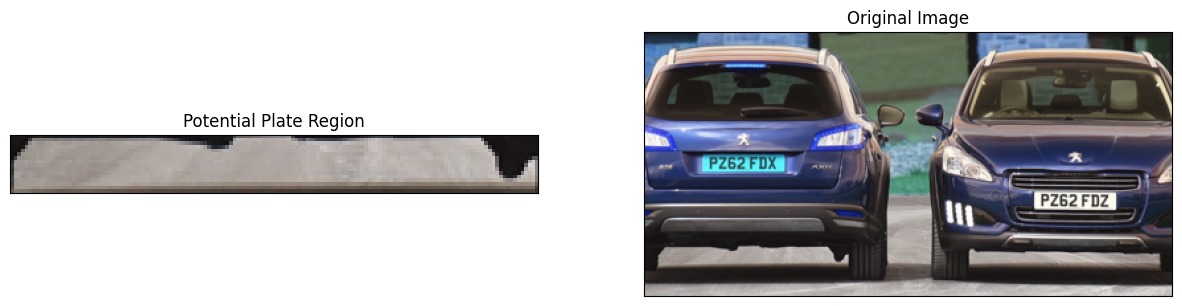

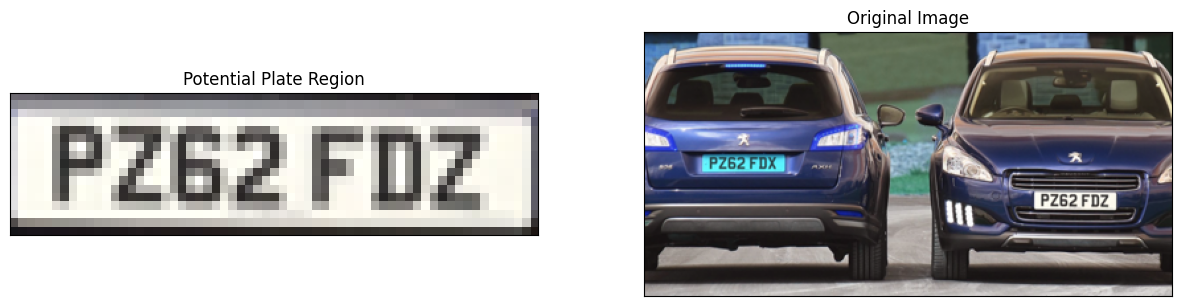

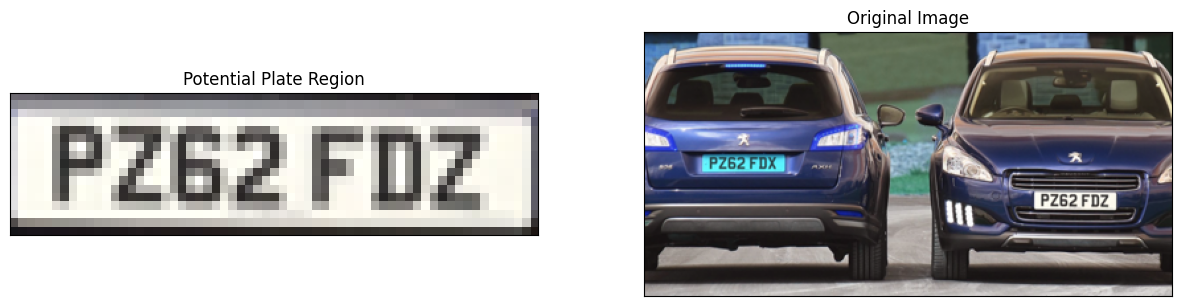

In [82]:
def show_cropped_regions(contours, image):
    plate = None
    plates = []
    for i in contours:
        a = cv2.arcLength(i, True)
        edge_count = cv2.approxPolyDP(i, 0.02 * a, True)
        if len(edge_count) in [4,5]:
            x, y, w, h = cv2.boundingRect(i)
            plate = image[y:y+h, x:x+w]
            plates.append(plate)
            # break
        
    n_plates = len(plates)
    
    #save all cropped regions wihtin the new specified folder
    for i in range(n_plates):
        cv2.imwrite(f"/home/zachgoldberg0/ml2_Project/ML2_Project/cropped-regions/plate{i}.png", plates[i])

    #show all stored cropped images
    for plate in plates:
        image_read(plate, image, title1 = "Potential Plate Region", title2 = "Original Image")
    
    #return the num of candidate regions to contain the license plate
    return n_plates

n_plates = show_cropped_regions(contours, image)

In [83]:
# for plate in plates:
#     image_read(plate, image, title1 = "Plate", title2 = "Original")

# Preprocessing The Cropped License Plate

In [84]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [85]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f"cv2.THRESH_BINARY :{cv2.THRESH_BINARY} \ncv2.THRESH_OTSU:{cv2.THRESH_OTSU}")
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

cv2.THRESH_BINARY :0 
cv2.THRESH_OTSU:8


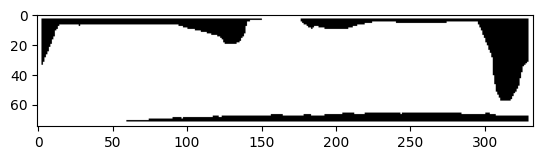

cv2.THRESH_BINARY :0 
cv2.THRESH_OTSU:8


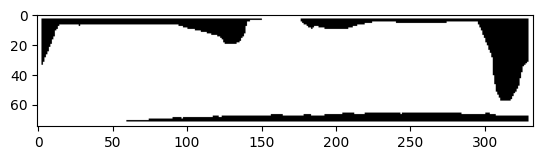

cv2.THRESH_BINARY :0 
cv2.THRESH_OTSU:8


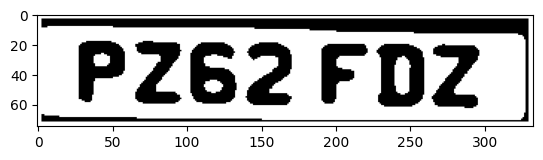

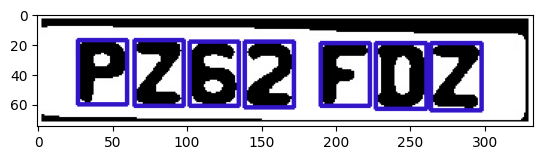

cv2.THRESH_BINARY :0 
cv2.THRESH_OTSU:8


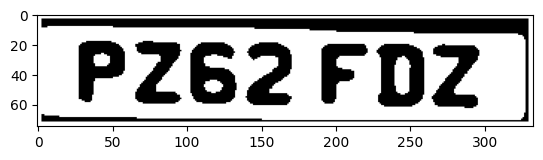

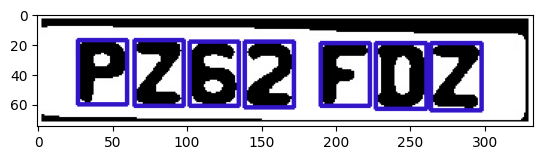

In [86]:
def search_characters_from_cropped_regions():
    chars=[]
    for i in range(n_plates):
        img = cv2.imread(f'/home/zachgoldberg0/ml2_Project/ML2_Project/cropped-regions/plate{i}.png')
        chars.append(segment_characters(img))

    return chars

chars = search_characters_from_cropped_regions()

Characters Extracted from the Plate:


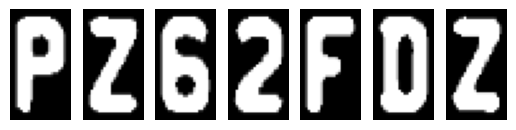

In [87]:
def show_character_images(chars):
    print("Characters Extracted from the Plate:")
    for i in range(n_plates):
        if len(chars[i])>=5:
            char = chars[i]
            for j in range(len(char)):
                plt.subplot(1, len(char), j+1)
                plt.imshow(char[j], cmap='gray')
                plt.axis('off')

    return char

char = show_character_images(chars)

In [88]:
# img = cv2.imread('/home/zachgoldberg0/ml2_Project/ML2_Project/car-data/images/Cars4.png')
# char = segment_characters(img)

Save all the extracted images of chars in a specific folder

In [89]:
# delete all other existing file in the directory
def save_character_images(char):
     directory = '/home/zachgoldberg0/ml2_Project/ML2_Project/font-data/extracted-plate'
     for f in os.listdir(directory):
          os.remove(os.path.join(directory, f))
          
     # Write new files in the directory
     char = [cv2.resize(image, (28, 28), interpolation = cv2.INTER_AREA) for image in char]
     for i in range(len(char)):
          cv2.imwrite(f'/home/zachgoldberg0/ml2_Project/ML2_Project/font-data/extracted-plate/char{i}.jpg',char[i])

save_character_images(char)

# Model For Characters Recognition

## Model Building and Training

In [90]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import datasets, transforms
import torchvision.transforms.functional as FV

In [91]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.ImageFolder(root='~/ml2_Project/ML2_Project/font-data/train', 
                                                 transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                               shuffle=True, num_workers=8)

dev_dataset = torchvision.datasets.ImageFolder(root='~/ml2_Project/ML2_Project/font-data/val', 
                                               transform=transform)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=64, 
                                             shuffle=False, num_workers=8)

In [92]:
data=iter(train_dataloader)
samples,labels=next(data)
print(f"number of samples{samples.shape}")
print(f"number of labels {labels.shape}")

number of samplestorch.Size([64, 1, 28, 28])
number of labels torch.Size([64])


In [93]:
# Fully connected neural network with four hidden layer
class MLP(nn.Module):
    def __init__(self, size):
        # size = [input_size, hidden_size, output_size/nbr_of_classes]
        # Sequential model definition: Input -> Linear -> ReLU -> Linear -> ReLU -> Linear -> ReLU -> Linear -> ReLU -> Linear -> Output
        super(MLP, self).__init__()
        self.model = nn.Sequential(nn.Linear(size[0], size[1]), nn.BatchNorm1d(size[1]), nn.ReLU(),
                                   nn.Linear(size[1], size[2]), nn.BatchNorm1d(size[2]), nn.ReLU(),
                                   nn.Linear(size[2], size[3]), nn.ReLU(),
                                   nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        out = self.model.forward(x)
        return out
    

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(384, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
    #    x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [94]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

batch_size = 64
learning_rate = 0.001

# Call the Model
model = CNN()

print(device)
print(model)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose =True)

cpu
CNN(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=36, bias=True)
)


In [95]:
def accuracy_score(y_true, y_pred):
    assert(len(y_true) ==len(y_pred))
    acc = sum(y_pred == y_true)/len(y_true)
    return acc

In [96]:
# Train model
def train_model(train_loader, model):
    training_loss = 0
    #Set model in training mode
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):  
        # Move tensors to the configured device
        # print(inputs.shape," ======== ", type(inputs))
        # inputs = inputs.view(inputs.shape[0], -1)
        inputs, targets = inputs.to(device), targets.to(device)
        #print(inputs.shape," ******** ", type(inputs))
        # targets = 
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        
    training_loss /= len(train_loader)
    return training_loss

In [97]:
# Evaluate the model

def evaluate_model(dev_loader, model):
    
    predictions = []
    actuals = []
    
    # Set model in validation mode
    model.eval()
    
    for i, (inputs, targets) in enumerate(dev_loader):
        # inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        targets = targets.to(device)
        # evaluate the model on the validation set
        # print(inputs.shape)
        out = model(inputs)
                
        # Calculate validation loss
        loss = criterion(out, targets)
        
        # convert to class labels
        _,out = torch.max(out.data,1)
        
        # retrieve numpy array from tensor
        out = out.cpu().detach().numpy()
        actual = targets.cpu().numpy()

        
        # reshape for stacking
        actual = actual.reshape(targets.shape)
        out = out.reshape(targets.shape)
        #print("ACTUAL: ", actual)
        # print("OUT: ", out)
        
        # reshape for stacking
        actual = actual.reshape(targets.shape)
        out = out.reshape(targets.shape)
        # store
        predictions.append(out)
        actuals.append(actual)
    
    predictions = [item for sublist in predictions for item in sublist]
    actuals = [item for sublist in actuals for item in sublist]
    
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # Calculate validation accuracy
    acc = accuracy_score(actuals, predictions)
    return acc, loss.item()

In [98]:
# Define number of epochs
num_epochs = 30

epochs = [epoch + 1 for epoch in range(num_epochs)]
training_loss = []
validation_loss = []
validation_accuracy = []

for epoch in range(num_epochs):
    
    # Train
    train_loss = train_model(train_dataloader, model)

    # Validation
    val_acc, val_loss = evaluate_model(dev_dataloader, model)

    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    validation_accuracy.append(val_acc)

    # scheduler 
    lr_scheduler.step(val_loss)
    # Print log of accuracy and loss
    print("Epoch: "+str(epoch+1)+", Training loss: "+str(train_loss)+", Validation loss:"+str(val_loss)+
          ", Validation accuracy:"+str(val_acc*100)+"%")
    
    # Save the model checkpoint
    if epoch>1 and validation_accuracy[epoch]> validation_accuracy[epoch-1]:
        torch.save(model.state_dict(), 'myModel.ckpt') # save the check point
    
    if val_acc > 0.97:
        torch.save(model.state_dict(), 'bestModel.ckpt') # save the check point
        

/tmp/ipykernel_26553/1230268075.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Epoch: 1, Training loss: 3.539979781423296, Validation loss:3.421144485473633, Validation accuracy:[16.66666667]%
Epoch: 2, Training loss: 3.137811081750052, Validation loss:2.526940107345581, Validation accuracy:[32.87037037]%
Epoch: 3, Training loss: 2.060272361551012, Validation loss:0.7099582552909851, Validation accuracy:[59.72222222]%
Epoch: 4, Training loss: 0.975170931645802, Validation loss:0.14844800531864166, Validation accuracy:[73.14814815]%
Epoch: 5, Training loss: 0.5929717591830662, Validation loss:0.10121583938598633, Validation accuracy:[79.16666667]%
Epoch: 6, Training loss: 0.3924452151571001, Validation loss:0.031199974939227104, Validation accuracy:[88.88888889]%
Epoch: 7, Training loss: 0.26353970382894787, Validation loss:0.08873311430215836, Validation accuracy:[91.66666667]%
Epoch: 8, Training loss: 0.2052356834922518, Validation loss:0.17341117560863495, Validation accuracy:[85.64814815]%
Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 9,

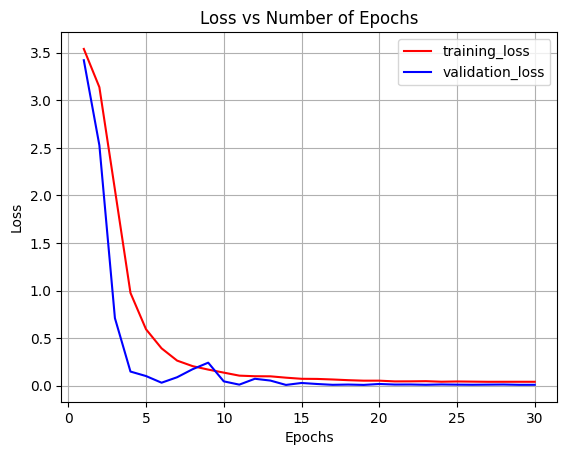

In [99]:
plt.plot(epochs, training_loss,'r', epochs, validation_loss, 'b')
plt.legend(['training_loss', 'validation_loss'])
plt.grid()
plt.title("Loss vs Number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Model Inference

In [100]:
# device = 'cpu'
# model.to(device)
# model.load_state_dict(torch.load("perfectModel.ckpt"))
# dummy_input = torch.randn(1, 784, device=device)
# torch.onnx.export(model, dummy_input, "myModel.onnx", verbose=True)

In [110]:
inference_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Resize((28,28)),
                                transforms.Normalize((0.5,), (0.5,))])

In [111]:
def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    # input = torch.reshape(input,(1,784))
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [112]:
def get_random_images(num):
    data = datasets.ImageFolder('~/ml2_Project/ML2_Project/font-data/val/', transform=inference_transform)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(dev_dataset, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    return images, labels

/tmp/ipykernel_26553/1230268075.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


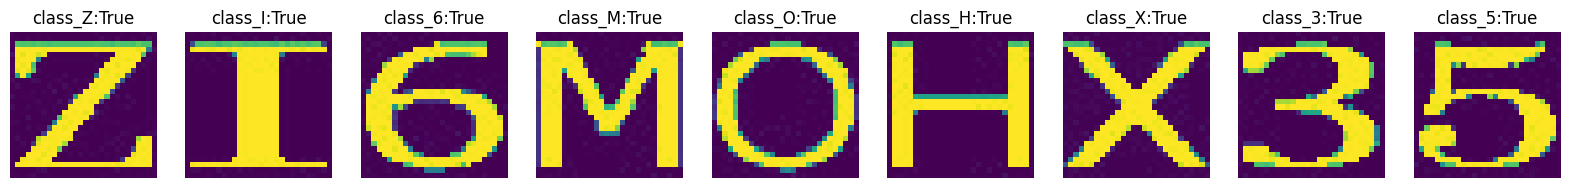

In [113]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(9)

data = datasets.ImageFolder('~/ml2_Project/ML2_Project/font-data/val/', transform=transform)
classes = data.classes

fig=plt.figure(figsize=(20,20))
for i in range(len(images)):
    image = to_pil(images[i])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), i+1)
    res = int(labels[i]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Predict with The License Plate Characters

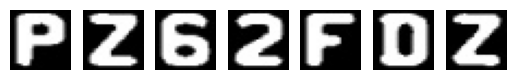

In [114]:
images=[]
for i in range(len(char)):
    img = cv2.imread(f'/home/zachgoldberg0/ml2_Project/ML2_Project/font-data/extracted-plate/char{i}.jpg')
    images.append(img)
    plt.subplot(1, len(char), i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

/tmp/ipykernel_26553/1230268075.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


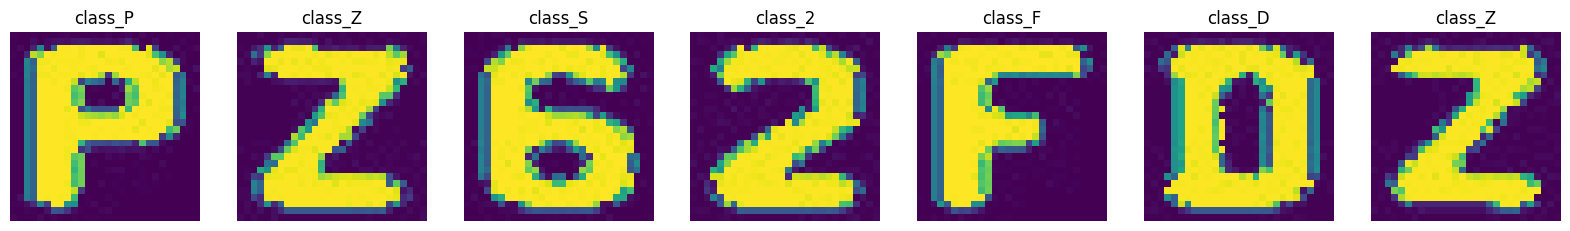


Hey, this plate number is: PZS2FDZ


In [115]:
import torchvision.transforms.functional as FV

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

images = [transforms.ToTensor()(images[i]) for i in range(len(images))]
images = [FV.resize(image, size=[28,28]) for image in images]
images = [transforms.Grayscale(num_output_channels=1)(image) for image in images]
images = [transforms.Normalize((0.5,), (0.5,))(image) for image in images]

fig=plt.figure(figsize=(20,20))
plate_str = ''
for i in range(len(images)):
    image = to_pil(images[i])
    index = predict_image(image)
    plate_str+=classes[index][-1]
    sub = fig.add_subplot(1, len(images), i+1)
    sub.set_title(str(classes[index]))
    plt.axis('off')
    plt.imshow(image)
plt.show()

print(f'\nHey, this plate number is: {plate_str}')

# END